<a href="https://colab.research.google.com/github/gibranfp/CursoAprendizajeProfundo/blob/master/notebooks/7a_dcgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DCGAN para generación de imágenes

In [1]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, Dropout
from tensorflow.keras.layers import LeakyReLU, ReLU, BatchNormalization, Input
from tensorflow.keras.layers import Activation, Reshape, Flatten
from tensorflow.keras import Model, Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import cifar10

from IPython.display import clear_output

tf.random.set_seed(1)
np.random.seed(2)

TensorFlow 2.x selected.


## Conjunto de datos CIFAR10
Vamos a trabajar con el conjunto de imágenes de Cifar 10, el cual consisde de 50000 imágenes de $32 \times 32 \times 3$ con valores $0-255$. Los valores se rescalan de -1 a 1:

In [2]:
(X_ent, y_ent), (_, _) = cifar10.load_data()
X_ent = (X_ent - 127.5) / 127.5 

ent_ds = tf.data.Dataset.from_tensor_slices(X_ent.astype('float32'))
ent_ds = ent_ds.shuffle(50000)
ent_ds = ent_ds.batch(128)
ent_ds = ent_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

170500096/170498071 [==============================] - 6s 0us/step


## Modelo
Ahora definimos nuestra red generativa antagónico. Primero definimos la red generadora:

In [0]:
generador = Sequential([Dense(4*4*1024, use_bias=False, input_shape=(100,)),
                        BatchNormalization(), 
                        ReLU(), 
                        Reshape((4, 4, 1024)),
                        Conv2DTranspose(512, (5, 5), strides=(2, 2), 
                                        padding='same', use_bias=False),
                        BatchNormalization(),
                        ReLU(),
                        Conv2DTranspose(256, (5, 5), strides=(2, 2), 
                                        padding='same', use_bias=False),
                        BatchNormalization(),
                        ReLU(),
                        Conv2DTranspose(3, (5, 5), strides=(2, 2), 
                                        padding='same', use_bias=False),
                        Activation('tanh')])


Definimos la arquitectura de la red discriminadora:

In [0]:
discriminador = Sequential([Conv2D(64, (4, 4), strides=(2, 2), 
                                   padding='same', input_shape=(28, 28, 3)),
                            BatchNormalization(),
                            LeakyReLU(alpha=0.2),
                            Conv2D(128, (4, 4), strides=(2, 2), 
                                   padding='same'),
                            BatchNormalization(),
                            LeakyReLU(alpha=0.2),
                            Conv2D(256, (4, 4), strides=(2, 2), 
                                   padding='same'),
                            BatchNormalization(),
                            LeakyReLU(alpha=0.2),
                            Flatten(),
                            Dense(1), 
                            Activation('sigmoid')])

## Entrenamiento

Definimos las funciones de pérdida para la generadora y la discriminadora:


In [0]:
class PerdidaGAN:
  def __init__(self):
    self.ecc = tf.keras.losses.BinaryCrossentropy()

  def gen(self, falsa):
    return self.ecc(tf.ones_like(falsa), falsa)

  def dis(self, real, falsa):
    perdida_real = self.ecc(tf.ones_like(real), real)
    perdida_falsa = self.ecc(tf.zeros_like(falsa), falsa)
    perdida_total = perdida_real + perdida_falsa

    return perdida_total

Generamos el funtor para la métrica de evaluación:

In [0]:
class MetricaGen:
  def __init__(self):
    self.ecc = tf.keras.metrics.BinaryCrossentropy()
  
  def __call__(self, falsa):
    self.ecc(tf.ones_like(falsa), falsa)
    
  def result(self):
    res = self.ecc.result().numpy()
    self.ecc.reset_states()
    return res

class MetricaDis:
  def __init__(self):
    self.ecc = tf.keras.metrics.BinaryCrossentropy()
  
  def __call__(self, real, falsa):
    self.ecc(tf.ones_like(real), real)
    self.ecc(tf.zeros_like(falsa), falsa)
    
  def result(self):
    res = self.ecc.result().numpy()
    self.ecc.reset_states()
    return res

Se entrena la red por 50 épocas:



Época 50: Perdida G = 1.5808883905410767 Pérdida D = 0.4240022897720337


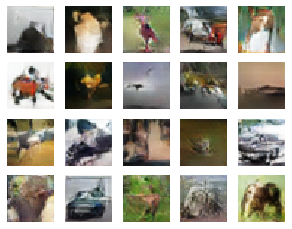

In [7]:
@tf.function
def paso_ent(x, opt_gen, opt_dis, discriminador, generador, fn_perdida):
  z = tf.random.normal([256, 100])
  
  with tf.GradientTape() as cinta_gen, tf.GradientTape() as cinta_dis:
    x_gen = generador(z, training=True)

    real = discriminador(x, training=True)
    falsa = discriminador(x_gen, training=True)
    
    perdida_gen = fn_perdida.gen(falsa)
    perdida_dis = fn_perdida.dis(real, falsa)
    
    grad_gen = cinta_gen.gradient(perdida_gen, generador.trainable_variables)
    grad_dis = cinta_dis.gradient(perdida_dis, discriminador.trainable_variables)

    opt_gen.apply_gradients(zip(grad_gen, generador.trainable_variables))
    opt_dis.apply_gradients(zip(grad_dis, discriminador.trainable_variables))

  return real, falsa

fn_perdida = PerdidaGAN()
opt_gen = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
opt_dis = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
mg = MetricaGen()
md = MetricaDis()
hist_gen = []
hist_dis = []

z_vis = tf.random.normal([20, 100])
for epoca in range(50):
  for x in ent_ds:
    real, falsa = paso_ent(x, opt_gen, opt_dis, discriminador, generador, fn_perdida)
    mg(falsa)
    md(real, falsa)
  
  mg_res = mg.result()
  md_res = md.result()
  hist_gen.append(mg_res)
  hist_dis.append(md_res)

  x_vis = generador(z_vis, training=False).numpy()
  x_vis = x_vis * 0.5 + 0.5

  clear_output(wait=True)
  print(u'Época {0}: Perdida G = {1} Pérdida D = {2}'.format(epoca + 1,
                                                             mg_res, 
                                                             md_res))
  
  plt.figure(figsize=(5,5))
  for i in range(x_vis.shape[0]):
    plt.subplot(5, 5, i + 1)
    plt.imshow(x_vis[i, :, :, :])
    plt.axis('off')
  plt.show()

Visualiza la pérdida de la red generadora y la red discriminadora:

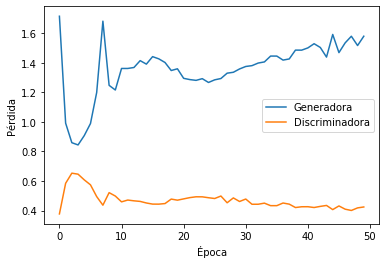

In [8]:
  plt.plot(hist_gen, label='Generadora')
  plt.plot(hist_dis, label='Discriminadora')
  plt.xlabel(u'Época')
  plt.ylabel(u'Pérdida')
  plt.legend()

Finalmente generamos y visualizamos una imagen:

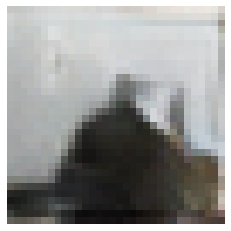

In [9]:
z_ej = tf.random.normal([1, 100])
x_ej = generador(z_ej, training=False).numpy()
x_ej = x_ej * 0.5 + 0.5
plt.imshow(x_vis[0, :, :, :])
plt.axis('off')
plt.show()